# Reduction script - spectra

## Configuration

In [1]:
dir = 'e:/Astro/Captures/20231008_Void/'
bias = 'Bias*.*'
darks = 'dark*.*'
flats = 'flat*.*'
sciences = 'deneb*.*'

masterbias = 'masterbias.fit'
masterdark = 'masterdark.fit'
masterflat = 'masterflat.fit'
sciencedata = 'sciencedata.fit'

overwrite_masters = False         # recreate masters or not ?
memory_limit = 1e9               # how much memory (bytes) to allocate to ccdproc combine ?

camera_electronic_gain = 1.2     # asi 183mm
camera_readout_noise = 2.2       # asi 183mm

## Imports libs

In [2]:
#%matplotlib widget
import warnings, fnmatch, os
from time import gmtime, strftime

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, QTable
from astropy import units as u
from astropy.nddata import CCDData, StdDevUncertainty
from astropy.stats import mad_std
from astropy.io import fits
from astropy.utils.exceptions import AstropyWarning

from ccdproc import Combiner, combine, subtract_bias, subtract_dark
from ccdproc import trim_image, Combiner, ccd_process, cosmicray_median

from align_combine import align_and_combine

warnings.simplefilter('ignore', category=AstropyWarning)


## Create logger

In [3]:
import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
consoleHandler = logging.StreamHandler()
consoleHandler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(message)s')
consoleHandler.setFormatter(formatter)
logger.addHandler(consoleHandler)
#logger.info('logger started')

## Create masters

In [ ]:
### prepare filenames lists
bias_files = [dir + f for f in fnmatch.filter(os.listdir(dir), bias)]
dark_files = [dir + f for f in fnmatch.filter(os.listdir(dir), darks)]
flat_files = [dir + f for f in fnmatch.filter(os.listdir(dir), flats)]
science_files  = [dir + f for f in fnmatch.filter(os.listdir(dir), sciences)]
logger.info('bias files : ' + repr(bias_files))
logger.info('dark files : ' + repr(dark_files))
logger.info('flat files : ' + repr(flat_files))
logger.info('science files : ' + repr(science_files))

### create masterbias
if (os.path.exists(dir + masterbias)) and (overwrite_masters is False):
    logger.info(masterbias + ' not (re)created')
else:
    logger.info('masterbias combine...')
    bias_list = [CCDData.read(f, unit = u.adu) for f in bias_files]
    bias_master = combine(bias_list, method='median', mem_limit = memory_limit)
    bias_master = CCDData(bias_master.data.astype('float32'), unit = u.adu, header = bias_master.header)
    bias_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    bias_master.meta['combined'] = True
    bias_master.meta['history'] = 'combined from {} bias file(s)'.format(len(bias_files))
    bias_master.write(dir + masterbias, overwrite=True)
    logger.info('masterbias created - combined from {} bias file(s)'.format(len(bias_files)))
    bias_list = None

### create masterdark
if (os.path.exists(dir + masterdark)) and (overwrite_masters is False):
    logger.info(masterdark + ' not (re)created')
else:
    darks_list = []
    for dark_file in dark_files:
        logger.info('masterbias sub {} ...'.format(dark_file))
        dark_data = CCDData.read(dark_file, unit = u.adu)
        dark_sub = subtract_bias(dark_data, bias_master)
        dark_sub = CCDData(dark_sub.data.astype('float32'), unit = u.adu, header = dark_data.header)
        dark_data = None
        darks_list.append(dark_sub)
    
    logger.info('masterdark combine...')
    dark_master = combine(darks_list, method='median', mem_limit = memory_limit)
    dark_master = CCDData(dark_master.data.astype('float32'), unit = u.adu, header = dark_master.header)
    dark_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    dark_master.meta['combined'] = True
    dark_master.meta['history'] = 'masterbias sub + combined from {} dark file(s)'.format(len(dark_files))
    dark_master.write(dir + masterdark, overwrite=True)
    logger.info('masterdark created - bias substracted + combined from {} dark file(s)'.format(len(dark_files)))
    darks_list = None

### create masterflat
if (os.path.exists(dir + masterflat)) and (overwrite_masters is False):
    logger.info(masterflat + ' not (re)created')
else:
    flats_list = []
    for flat_file in flat_files:
        logger.info('masterbias sub {} ...'.format(flat_file))
        flat_data = CCDData.read(flat_file, unit = u.adu)
        flat_sub = subtract_bias(flat_data, bias_master)
        flat_sub = CCDData(flat_sub.data.astype('float32'), unit = u.adu, header = flat_data.header)
        flat_data = None
        flats_list.append(flat_sub)
    
    logger.info('masterflat combine...')
    flat_master = combine(flats_list, method='median', mem_limit = memory_limit)
    flat_master = CCDData(flat_master.data.astype('float32'), unit = u.adu, header = flat_master.header)
    flat_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    flat_master.meta['combined'] = True
    flat_master.meta['history'] = 'bias substracted + combined from {} flat file(s)'.format(len(flat_files))
    flat_master.write(dir + masterflat, overwrite=True)
    logger.info('masterflat created : bias substracted + combined from {} flat file(s)'.format(len(flat_files)))
    flats_list = None

### process science files
master_bias = CCDData.read(dir + masterbias, unit = u.adu)
master_dark = CCDData.read(dir + masterdark, unit = u.adu)
master_flat = CCDData.read(dir + masterflat, unit = u.adu)
for sci_file in science_files:
    logger.info('processing (masterbias sub + masterdark sub + masterflat divide) {} ...'.format(sci_file))
    sci_data = CCDData.read(sci_file, unit = u.adu)
    sci_data_processed = ccd_process(sci_data, 
            oscan = None, 
            gain_corrected = False, 
            trim = None, 
            error = False,
            gain=camera_electronic_gain*u.electron/u.adu,
            readnoise=camera_readout_noise*u.electron,
            master_bias = master_bias,
            dark_frame=master_dark,
            master_flat=master_flat,
            exposure_key='EXPTIME',
            exposure_unit=u.second,
            dark_scale=True)
    sci_ok = CCDData(sci_data_processed.data.astype('float32'), unit = u.adu, header = sci_data.header)
    #sci_list.append(sci_ok)
    logger.info('writing science datafile (-ppr) {}'.format(sci_file))
    sci_ok.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    sci_ok.meta['combined'] = True
    sci_ok.meta['history'] = 'bias substracted + dark substrated + flat divide'
    sci_ok.write(Path(sci_file).with_stem(f"{'ppr'}-{Path(sci_file).stem}"), overwrite=True)
    
### align images and combine using a SUM
science_files_ppr  = [dir + f for f in fnmatch.filter(os.listdir(dir), 'ppr-*' + sciences)]
logger.info('science files to combine (align and sum) : ' + repr(science_files_ppr))
sci_aligned = align_and_combine(science_files_ppr, np.sum)
sci_master = CCDData(sci_aligned, unit = u.adu, header = sci_ok.header)
sci_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
sci_master.meta['combined'] = True
sci_master.meta['history'] = 'sum combined + aligned from {} sciences file(s)'.format(len(science_files))
sci_master.write(dir + sciencedata, overwrite=True)
logger.info('combined + aligned + sum from {} sciences file(s)'.format(len(science_files)))

### remove cosmic
sci__cleaned = ccdproc.cosmicray_median(sci_master, thresh = 5, mbox=11, rbox=11, gbox=5, error_image = None)
sci__cleaned.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
sci__cleaned.meta['history'] = 'cosmicray median removed'
sci__cleaned.write(dir + 'final-' + sciencedata, overwrite=True)
logger.info('final-' + sciencedata + ' created')


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Text(0.5, 1.0, 'master_science_cosmicray_removed')

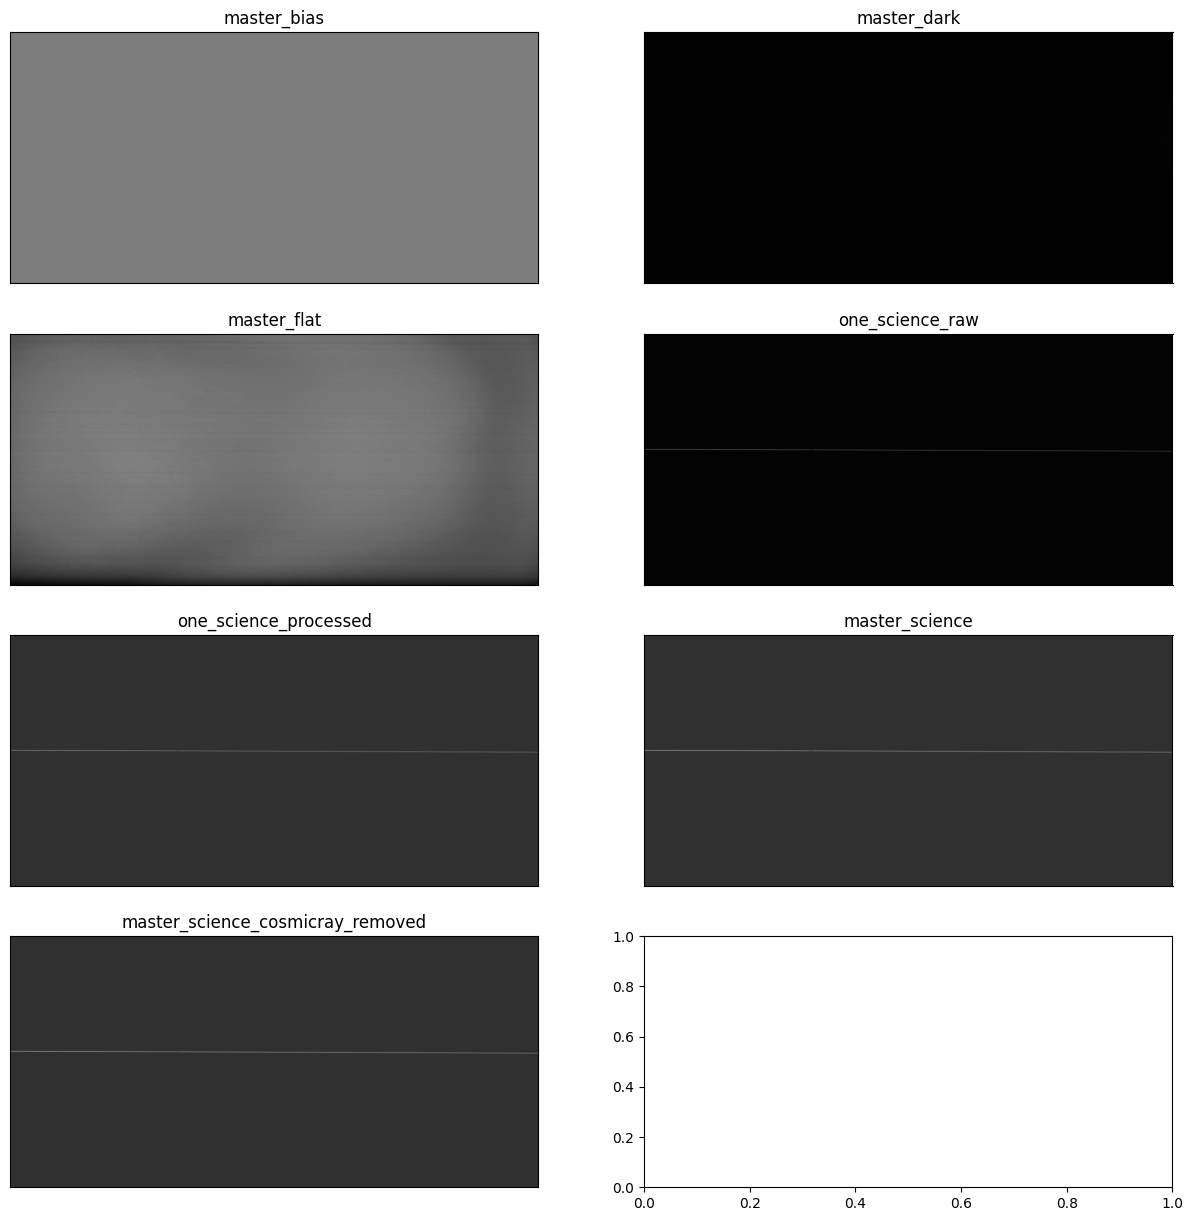

In [27]:
master_bias = CCDData.read(dir + masterbias, unit = u.adu)
master_dark = CCDData.read(dir + masterdark, unit = u.adu)
master_flat = CCDData.read(dir + masterflat, unit = u.adu)
science_files  = [dir + f for f in fnmatch.filter(os.listdir(dir), sciences)]
ppr_science_files  = [dir + f for f in fnmatch.filter(os.listdir(dir), 'ppr-' + sciences)]
one_science = CCDData.read(science_files[0], unit = u.adu)
one_science_ppr = CCDData.read(ppr_science_files[0], unit = u.adu)
master_science = CCDData.read(dir + sciencedata, unit = u.adu)
master_science_cosmic = CCDData.read(dir + 'final-' + sciencedata, unit = u.adu)

#cmap = plt.cm.magma
colormap = plt.cm.grey
cuts = (5, 99.)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(15, 15))

im1 = ax1.imshow(master_bias, origin='lower', aspect='auto', cmap=colormap)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
im.set_clim(np.percentile(master_bias, cuts))
ax1.set_title('master_bias')
#cb = plt.colorbar()

im2 = ax2.imshow(master_dark, origin='lower', aspect='auto', cmap=colormap)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
im2.set_clim(np.percentile(master_dark, cuts))
ax2.set_title('master_dark')
#cb = plt.colorbar()

im3 = ax3.imshow(master_flat, origin='lower', aspect='auto', cmap=colormap)
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)
im3.set_clim(np.percentile(master_flat, cuts))
ax3.set_title('master_flat')
#cb = plt.colorbar()

im4 = ax4.imshow(one_science, origin='lower', aspect='auto', cmap=colormap)
ax4.xaxis.set_visible(False)
ax4.yaxis.set_visible(False)
im4.set_clim(np.percentile(one_science, cuts))
ax4.set_title('one_science_raw')
#cb = plt.colorbar()

im5 = ax5.imshow(one_science_ppr, origin='lower', aspect='auto', cmap=colormap)
ax5.xaxis.set_visible(False)
ax5.yaxis.set_visible(False)
im5.set_clim(np.percentile(one_science_ppr, cuts))
ax5.set_title('one_science_processed')
#cb = plt.colorbar()

im6 = ax6.imshow(master_science, origin='lower', aspect='auto', cmap=colormap)
ax6.xaxis.set_visible(False)
ax6.yaxis.set_visible(False)
im6.set_clim(np.percentile(master_science, cuts))
ax6.set_title('master_science')
#cb = plt.colorbar()

im7 = ax7.imshow(master_science_cosmic, origin='lower', aspect='auto', cmap=colormap)
ax7.xaxis.set_visible(False)
ax7.yaxis.set_visible(False)
im7.set_clim(np.percentile(master_science_cosmic, cuts))
ax7.set_title('master_science_cosmicray_removed')
#cb = plt.colorbar()


images deltas = [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]


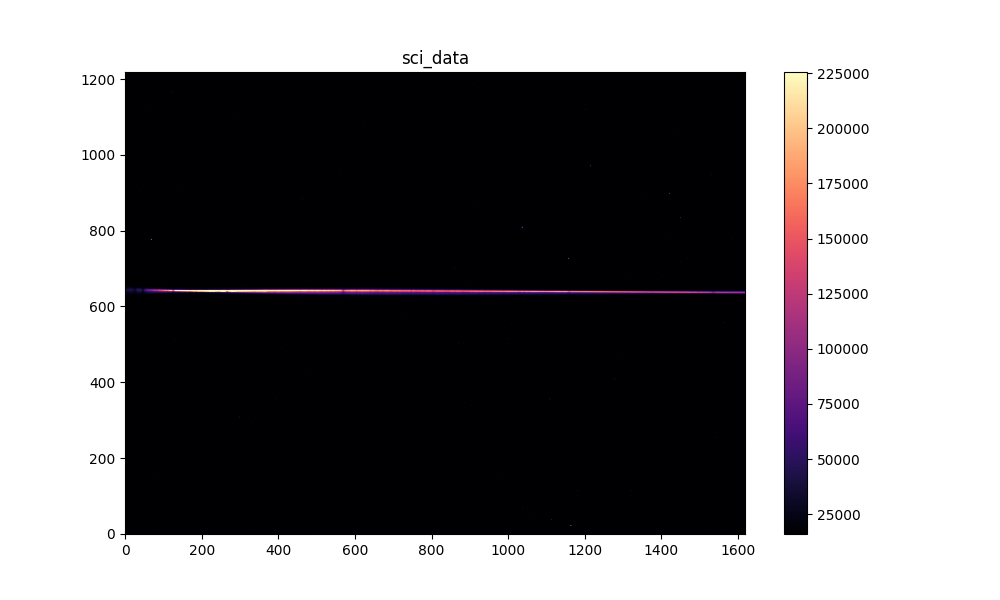

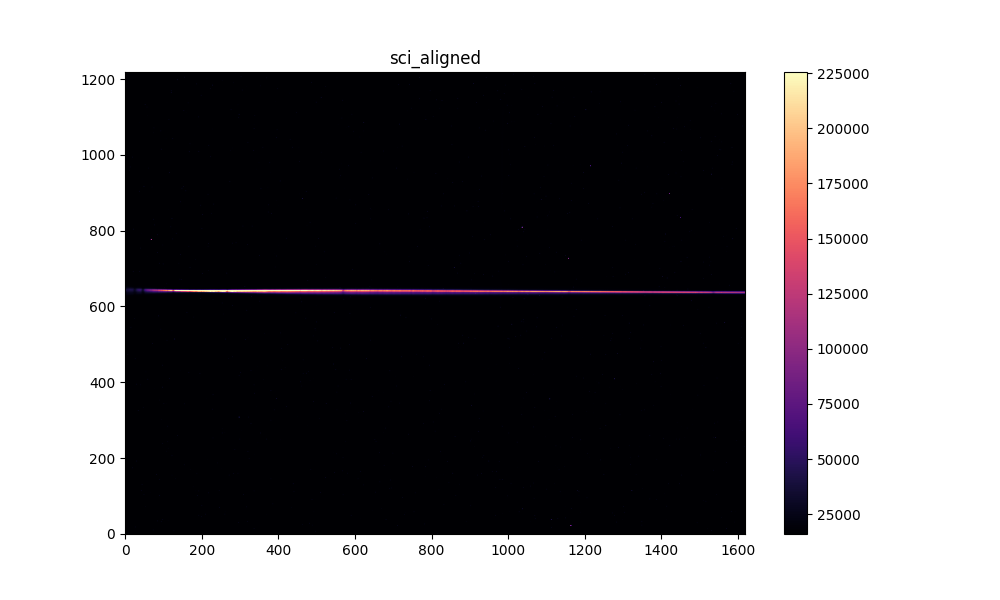

In [41]:
from align_combine import align_and_combine
dir = 'e:/Astro/Captures/20231007_Void/'
#dir = 'E:/Astro/Captures/20181020_spectro/'

#sci_files  = [dir + f for f in fnmatch.filter(os.listdir(dir), 'bwvull-*.fit')]
sci_files  = [dir + f for f in fnmatch.filter(os.listdir(dir), '10lac-300s-*.fit')]

sci_datas = [CCDData.read(f, unit = u.adu) for f in sci_files]
sci_data = np.sum(sci_datas, axis = 0, dtype = np.float32)


plt.figure(figsize=(10,6))
plt.imshow(sci_data, origin='lower', aspect='auto', cmap=plt.cm.magma)
plt.title('sci_data')
plt.clim(np.percentile(sci_data, (5, 99.95)))
cb = plt.colorbar()


sci_aligned = align_and_combine(sci_files, np.sum)
plt.figure(figsize=(10,6))
plt.imshow(sci_aligned, origin='lower', aspect='auto', cmap=plt.cm.magma)
plt.title('sci_aligned')
plt.clim(np.percentile(sci_aligned, (5, 99.95)))
cb = plt.colorbar()



In [3]:
#sci_data.header['EXPOSURE'] = sci_data.header['EXPTIME']  # for dark subtraction

sci_data = ccdproc.ccd_process(sci_data, oscan=None, gain_corrected=False,
                           trim=None,
                           gain=2.0*u.electron/u.adu,
                           readnoise=5*u.electron,
                           dark_frame=master_dark,
                           master_bias = master_bias,
                           exposure_key='EXPTIME',
                           exposure_unit=u.second,
                           dark_scale=True,
                           master_flat=master_flat)


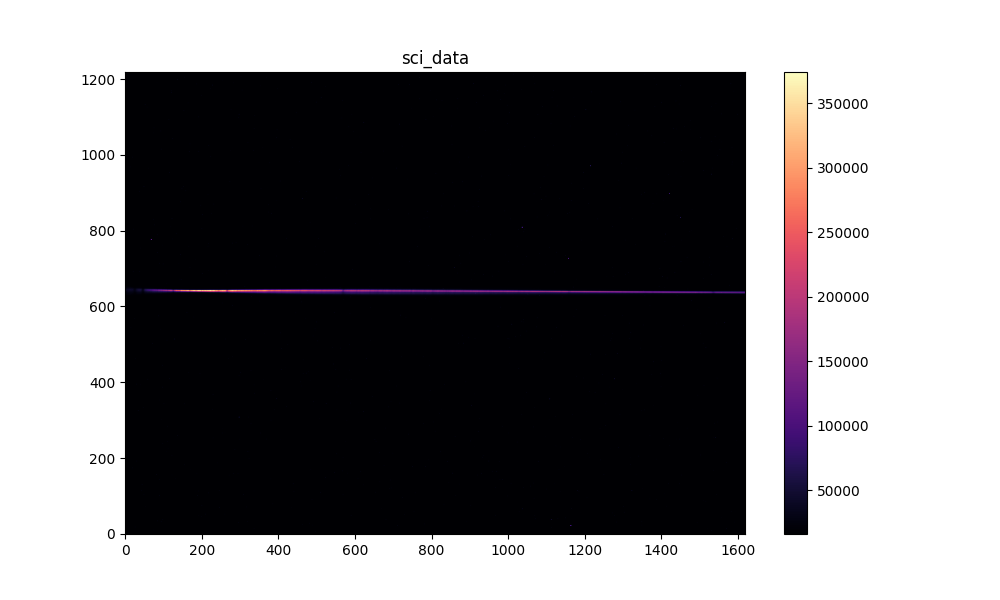

In [54]:
plt.figure(figsize=(10,6))
plt.imshow(sci_data, origin='lower', aspect='auto', cmap=plt.cm.magma)
plt.title('sci_data')
plt.clim(np.percentile(sci_data, (5, 99.99)))
cb = plt.colorbar()


In [57]:
#newccd = ccdproc.cosmicray_median(nccd, thresh=5, mbox=11, rbox=11, gbox=5) 
#cr_cleaned = ccdproc.cosmicray_lacosmic(nccd, sigclip=1)
cr_cleaned = ccdproc.cosmicray_median(sci_data, thresh = 3, mbox=5, rbox=5, gbox=5, error_image = None) #np.ones(sci_data.shape))
cr_cleaned

(array([[15926., 16126., 16193., ..., 16061., 15893., 15992.],
        [16169., 16368., 16168., ..., 16204., 16076., 16220.],
        [16114., 16410., 16218., ..., 16190., 16030., 16154.],
        ...,
        [16652., 16632., 16726., ..., 16501., 16509., 16626.],
        [16681., 16831., 16785., ..., 16221., 16606., 16522.],
        [16448., 16777., 16808., ..., 16536., 16405., 16371.]],
       dtype=float32),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]))

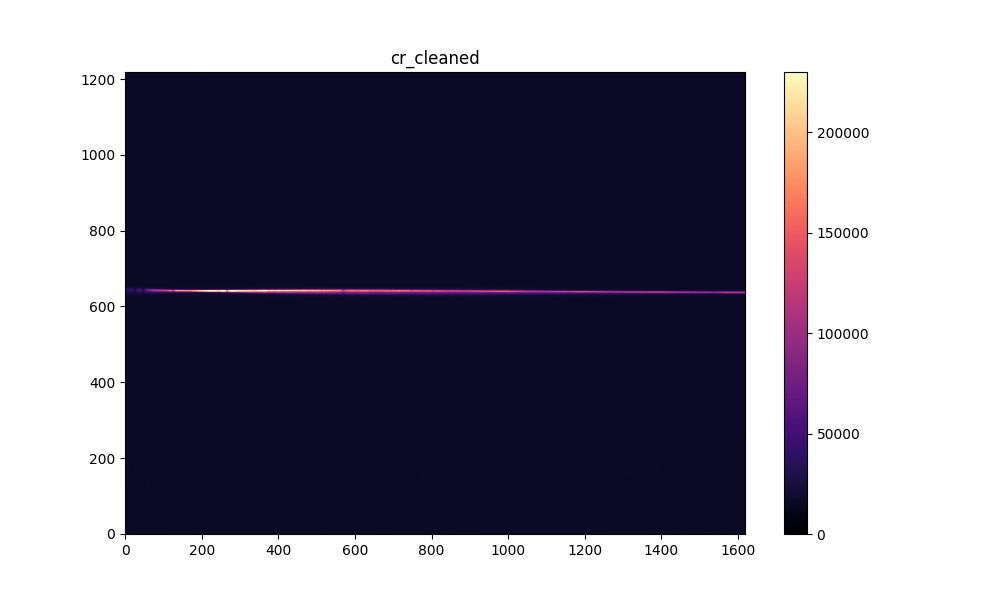

In [58]:
plt.figure(figsize=(10,6))
plt.imshow(cr_cleaned[0], origin='lower', aspect='auto', cmap=plt.cm.magma)
plt.title('cr_cleaned')
plt.clim(np.percentile(cr_cleaned, (5, 99.99)))
cb = plt.colorbar()

In [83]:
from specreduce import tracing, background, extract
sci_tr = tracing.FitTrace(nccd,  peak_method='max')   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
bg = background.Background.two_sided(nccd, sci_tr, separation=50, width=50) 
extract = extract.BoxcarExtract(nccd - bg, sci_tr, width = 5)
sci_spectrum = extract()


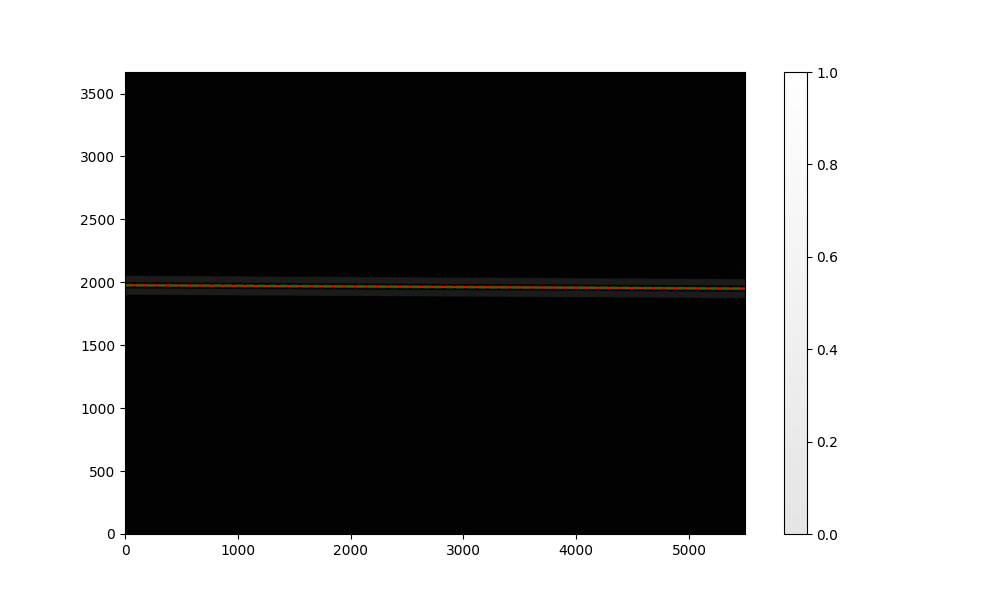

In [11]:
plt.figure(figsize=(10,6))
plt.imshow(sci_data, origin='lower', aspect='auto', cmap=plt.cm.gray)
plt.imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
plt.plot(sci_tr.trace , color='r')
plt.plot(sci_tr.trace+extract.width , color='g', linestyle='dashed', alpha=0.5)
plt.plot(sci_tr.trace-extract.width , color='g', linestyle='dashed', alpha=0.5)

cb = plt.colorbar()



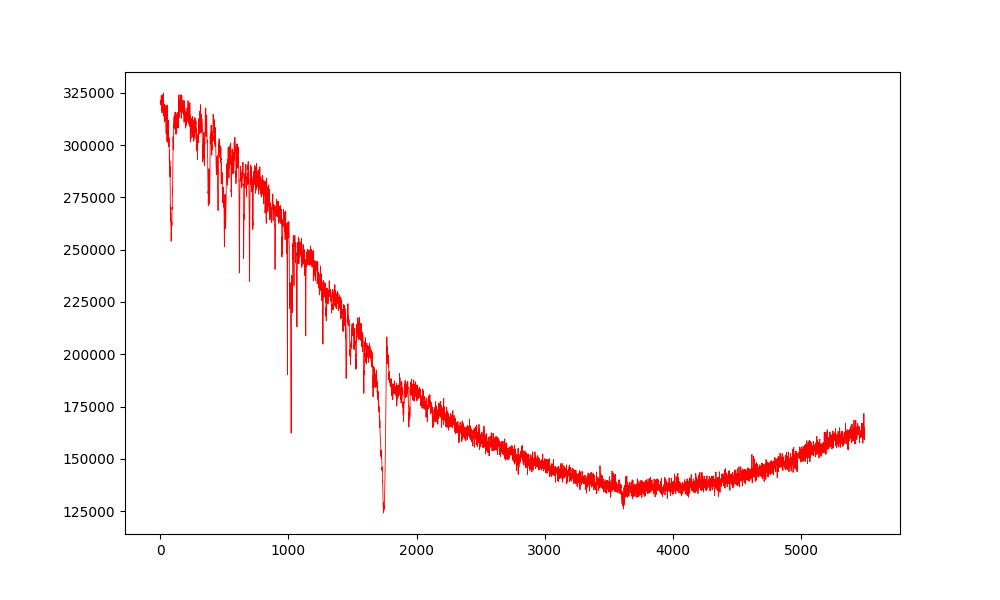

In [84]:
plt.figure(figsize=(10,6))
plt.plot(sci_spectrum.flux, color='r',  linewidth = '0.6')


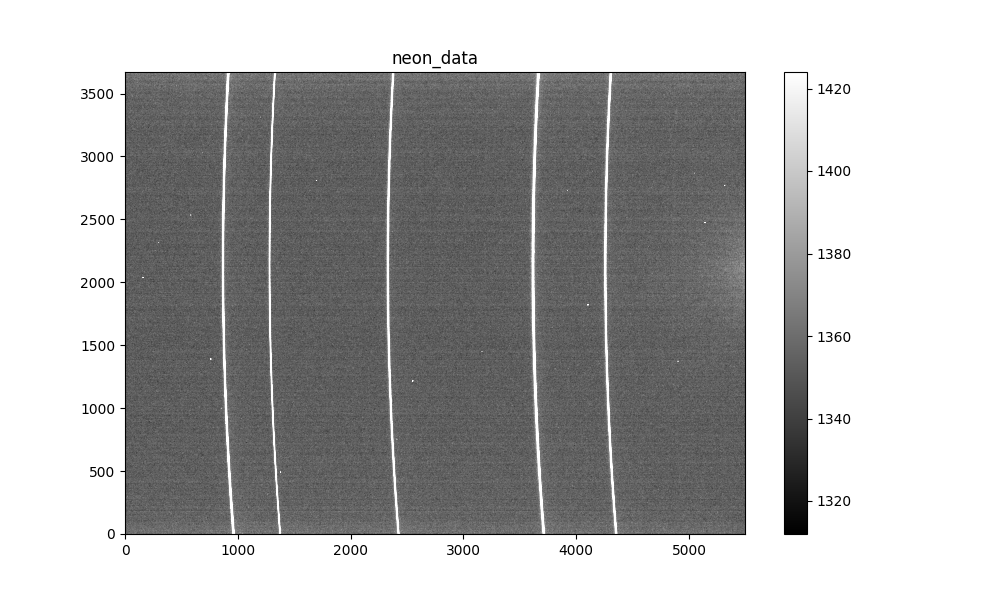

In [26]:
dir = 'e:/Astro/Captures/20231008_Void/'
neon_data = CCDData.read(dir + 'neon-15s-2.fit', unit = u.adu)
plt.figure(figsize=(10,6))
plt.imshow(neon_data, origin='lower', aspect='auto', cmap=plt.cm.grey)
plt.title('neon_data')
plt.clim(np.percentile(sci_data, (10, 90)))
cb = plt.colorbar()

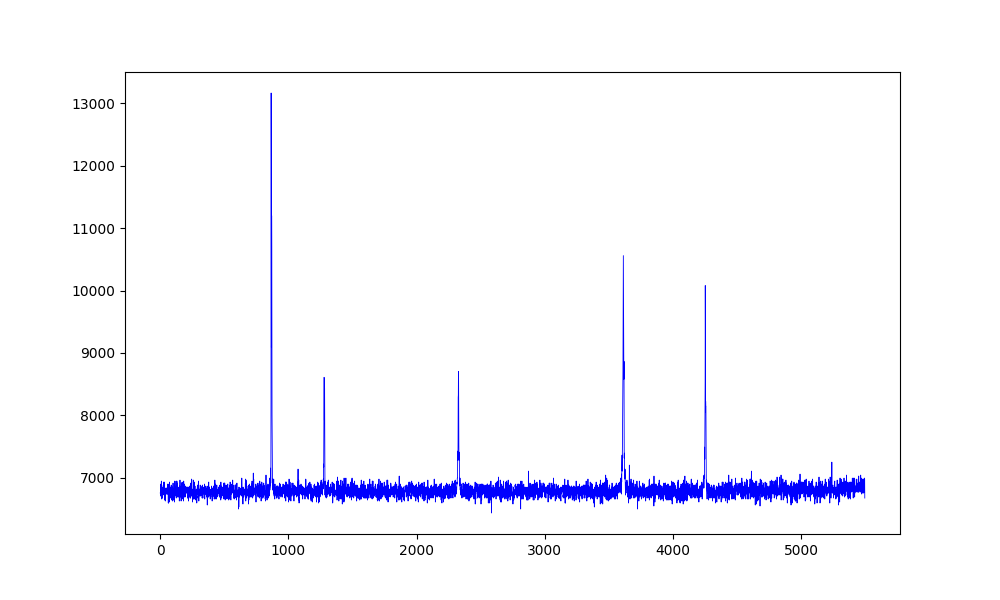

In [85]:
from specreduce import tracing, background, extract
#specreduce.tracing.ArrayTrace(image: NDData, trace: ndarray)
neon_tr = tracing.ArrayTrace(neon_data, [1900, 2000])   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
#bg = background.Background.two_sided(nccd, sci_tr, separation=50, width=50) 
extract = extract.BoxcarExtract(neon_data , neon_tr, width = 5)
neon_spectrum = extract()
plt.figure(figsize=(10,6))
plt.plot(neon_spectrum.flux, color='b',  linewidth = '0.6')



[-0.6745298   0.43377463  0.55365824 -0.11024465 -0.20265843] Angstrom
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           slope            intercept    
       Angstrom / pix        Angstrom    
    ------------------- -----------------
    0.06186690092200992 6453.504059796365


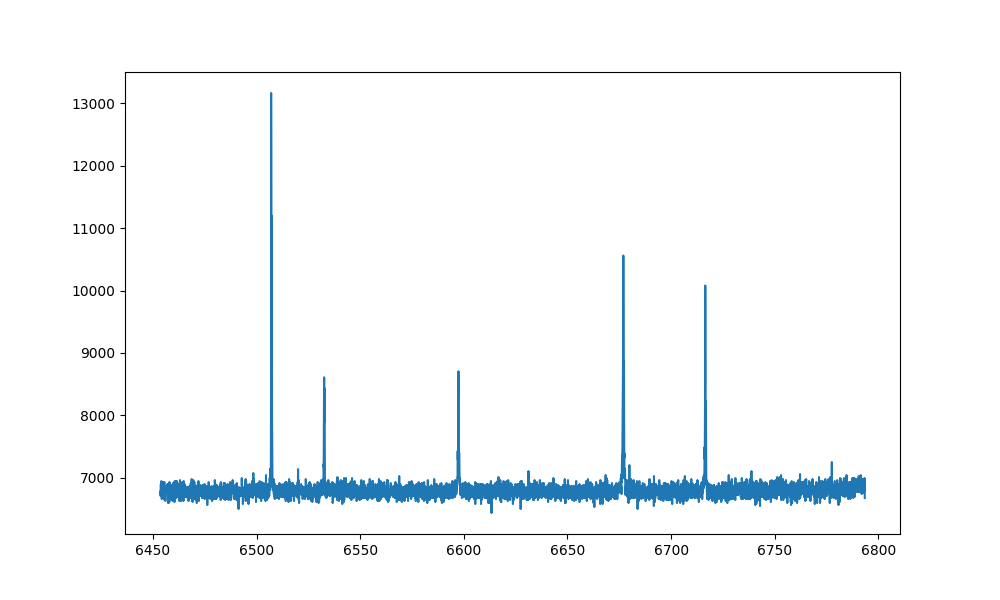

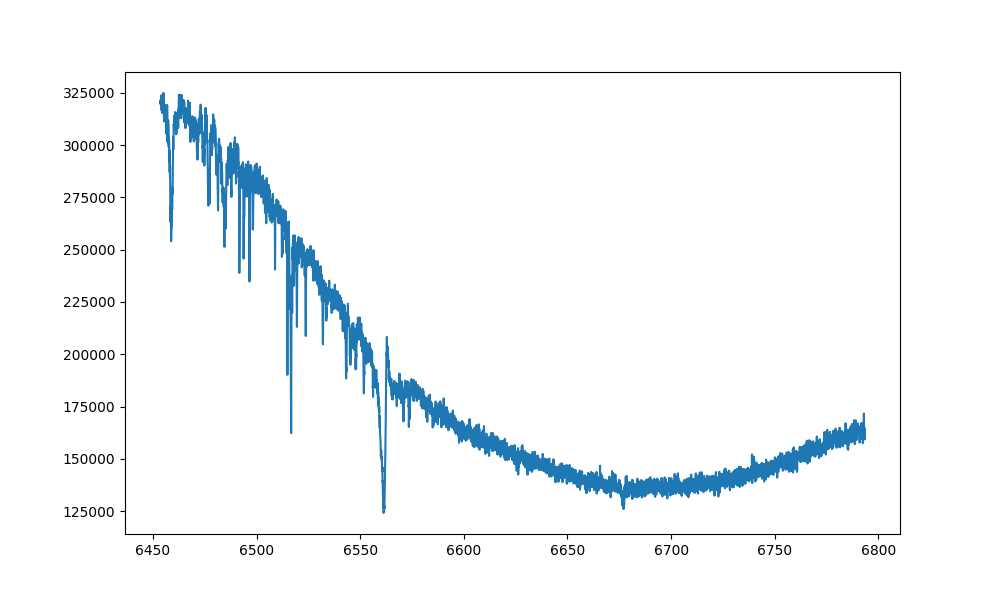

In [89]:
import astropy.units as u
from specreduce import WavelengthCalibration1D


pixels = [868, 1276, 2342, 3635, 4263]*u.pix
wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA
line_list = QTable([pixels, wavelength], names=["pixel_center", "wavelength"])
test_cal = WavelengthCalibration1D(neon_spectrum, matched_line_list=line_list)
print(test_cal.residuals )
print(test_cal.fitted_model )
neon_calibrated_spectrum = test_cal.apply_to_spectrum(neon_spectrum)
sci_calibrated_spectrum = test_cal.apply_to_spectrum(sci_spectrum)

plt.figure(figsize=(10,6))
plt.plot(neon_calibrated_spectrum.spectral_axis, neon_calibrated_spectrum.flux)  

plt.figure(figsize=(10,6))
plt.plot(sci_calibrated_spectrum.spectral_axis, sci_calibrated_spectrum.flux)  


''
